## 0. Libarary 불러오기 및 경로설정

In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from torchvision import models
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize, CenterCrop

In [2]:
train_dir = '/opt/ml/input/data/train'

## 2. Train Dataset 정의

In [11]:
class TrainDataset(Dataset):
    def __init__(self,img_paths,labels,trans_dict,val=False):
        self.img_paths = img_paths
        self.labels = labels
        self.trans_dict = trans_dict
        self.val = val
        
    def __getitem__(self,index):
        image = Image.open(self.img_paths[index])
        label = self.labels[index]
        if self.trans_dict:
            if self.val:
                image = self.trans_dict['val'](image)
            elif label in [0,1,3,4]:
                image = self.trans_dict['train1'](image)
            else:
                image = self.trans_dict['train2'](image)
        
        return image,label

    def __len__(self):
        return len(self.img_paths)

## 3. DataLoader 정의

sample 이미지 살펴보고 transform 결정

4


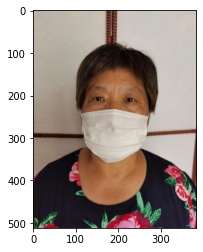

In [244]:
import matplotlib.pyplot as plt
%matplotlib inline

image = Image.open(image_paths[47])
print(labels[47])
plt.imshow(image)

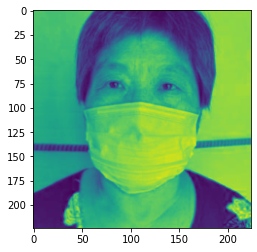

In [253]:
image2 = data_transform['train1'](image)
plt.imshow(image2[0])

In [21]:
#hyperparam 정의
num_epoch = 10
num_classes = 18
batch_size = 16
val_split = 0.2
random_seed= 42
shuffle_dataset = True

In [256]:
# meta 데이터와 이미지 경로를 불러옵니다.
train_info = pd.read_csv(os.path.join(train_dir, 'train3.csv'))
image_paths = train_info['path']
labels = train_info['category']

#transform 정의
data_transform = {
    'train1': transforms.Compose([
                CenterCrop(300),  
                Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),
                ToTensor(),
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
            ]),
    'train2': transforms.Compose([
                    CenterCrop(300),  
                    Resize((224, 224)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomApply(transforms=[transforms.ColorJitter(brightness=0.5)],p=0.5),
                    #transforms.RandomApply(transforms=[transforms.Pad(padding=5, fill=0, padding_mode='constant')],p=0.5),
                    transforms.RandomApply(transforms=[transforms.RandomPerspective(distortion_scale=0.2, p=0.5)],p=0.5),
                    ToTensor(),
                    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2))
                ]),
    'val': transforms.Compose([
                Resize((224, 224), Image.BILINEAR),
                ToTensor(),
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
            ])
}

#train val split
dataset_size = len(labels)
indices = list(range(dataset_size))
split = int(np.floor(val_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_dataset = TrainDataset(list(image_paths[train_indices]),list(labels[train_indices]),data_transform)
val_dataset = TrainDataset(list(image_paths[val_indices]),list(labels[val_indices]),data_transform,val=True)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False
)
print(len(train_dataset),len(val_dataset),dataset_size)

15120 3780 18900


## 4. Model 정의

In [254]:
from custom_models import ResnetModel as MyModel

## 5. Train

In [261]:
from sklearn.metrics import f1_score
import numpy as np
from loss import f1_loss

# 모델을 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel(num_classes=num_classes).to(device)
model.train()

#loss function, optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

#모델 학습
from tqdm import tqdm
right_count = [0 for _ in range(num_classes)]
wrong_count = [0 for _ in range(num_classes)]

for epoch in tqdm(range(num_epoch)):
    cur_loss,cur_f1=0.0,0.0
    for i,data in enumerate(train_dataloader):
        images,labels = data
        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        
        images.to(device)
        model_output = model(images)
        loss = criterion(model_output,labels)
        loss.backward()
        optimizer.step()
        
        cur_loss += loss.item()
        f1 = f1_loss(labels,model_output)
        cur_f1 += f1
        predict = model_output.argmax(dim=-1)
        for k in range(batch_size):
            if predict[k]==labels[k]:
                right_count[labels[k]]+=1
            else:
                wrong_count[labels[k]]+=1
        if i%100==99:
            print('[%d,%5d] loss: %.3f,f1:%.3f'% (epoch+1,i+1,cur_loss/100,cur_f1/100))
            cur_loss,cur_f1=0.0,0.0
            
print('training finished')

  0%|          | 0/10 [00:00<?, ?it/s]

[1,  100] loss: 2.051,f1:5.323
[1,  200] loss: 1.432,f1:7.539
[1,  300] loss: 1.326,f1:7.940
[1,  400] loss: 1.200,f1:8.372
[1,  500] loss: 1.111,f1:8.384
[1,  600] loss: 1.068,f1:8.447
[1,  700] loss: 1.030,f1:8.706
[1,  800] loss: 0.996,f1:8.613
[1,  900] loss: 0.959,f1:8.225


 10%|█         | 1/10 [01:23<12:32, 83.59s/it]

[2,  100] loss: 0.975,f1:8.551
[2,  200] loss: 0.882,f1:8.392
[2,  300] loss: 0.920,f1:8.420
[2,  400] loss: 0.865,f1:8.736
[2,  500] loss: 0.873,f1:8.638
[2,  600] loss: 0.845,f1:8.625
[2,  700] loss: 0.841,f1:8.803
[2,  800] loss: 0.848,f1:8.736
[2,  900] loss: 0.801,f1:8.355


 20%|██        | 2/10 [02:47<11:09, 83.70s/it]

[3,  100] loss: 0.839,f1:8.638
[3,  200] loss: 0.780,f1:8.512
[3,  300] loss: 0.828,f1:8.456
[3,  400] loss: 0.775,f1:8.721
[3,  500] loss: 0.791,f1:8.649
[3,  600] loss: 0.771,f1:8.656
[3,  700] loss: 0.799,f1:8.899
[3,  800] loss: 0.782,f1:8.837
[3,  900] loss: 0.745,f1:8.355


 30%|███       | 3/10 [04:11<09:45, 83.69s/it]

[4,  100] loss: 0.796,f1:8.603
[4,  200] loss: 0.728,f1:8.577
[4,  300] loss: 0.774,f1:8.444
[4,  400] loss: 0.737,f1:8.852
[4,  500] loss: 0.761,f1:8.670
[4,  600] loss: 0.749,f1:8.703
[4,  700] loss: 0.748,f1:8.872
[4,  800] loss: 0.727,f1:8.812
[4,  900] loss: 0.713,f1:8.298


 40%|████      | 4/10 [05:34<08:21, 83.66s/it]

[5,  100] loss: 0.778,f1:8.616
[5,  200] loss: 0.692,f1:8.612
[5,  300] loss: 0.769,f1:8.422
[5,  400] loss: 0.737,f1:8.782
[5,  500] loss: 0.748,f1:8.737
[5,  600] loss: 0.736,f1:8.672
[5,  700] loss: 0.782,f1:8.902
[5,  800] loss: 0.721,f1:8.814
[5,  900] loss: 0.714,f1:8.347


 50%|█████     | 5/10 [07:00<07:01, 84.29s/it]

[6,  100] loss: 0.736,f1:8.704
[6,  200] loss: 0.684,f1:8.590
[6,  300] loss: 0.766,f1:8.486
[6,  400] loss: 0.733,f1:8.817
[6,  500] loss: 0.728,f1:8.727
[6,  600] loss: 0.722,f1:8.720
[6,  700] loss: 0.750,f1:8.879
[6,  800] loss: 0.685,f1:8.834
[6,  900] loss: 0.714,f1:8.360


 60%|██████    | 6/10 [08:24<05:37, 84.32s/it]

[7,  100] loss: 0.733,f1:8.651
[7,  200] loss: 0.656,f1:8.622
[7,  300] loss: 0.752,f1:8.490
[7,  400] loss: 0.703,f1:8.780
[7,  500] loss: 0.729,f1:8.706
[7,  600] loss: 0.699,f1:8.711
[7,  700] loss: 0.732,f1:8.951
[7,  800] loss: 0.710,f1:8.819
[7,  900] loss: 0.704,f1:8.372


 70%|███████   | 7/10 [09:48<04:12, 84.16s/it]

[8,  100] loss: 0.732,f1:8.752
[8,  200] loss: 0.646,f1:8.616
[8,  300] loss: 0.752,f1:8.485
[8,  400] loss: 0.692,f1:8.800
[8,  500] loss: 0.718,f1:8.704
[8,  600] loss: 0.685,f1:8.773
[8,  700] loss: 0.738,f1:8.884
[8,  800] loss: 0.684,f1:8.848
[8,  900] loss: 0.670,f1:8.361


 80%|████████  | 8/10 [11:12<02:47, 83.91s/it]

[9,  100] loss: 0.709,f1:8.747
[9,  200] loss: 0.656,f1:8.641
[9,  300] loss: 0.710,f1:8.558
[9,  400] loss: 0.679,f1:8.815
[9,  500] loss: 0.723,f1:8.727
[9,  600] loss: 0.683,f1:8.763
[9,  700] loss: 0.694,f1:8.900
[9,  800] loss: 0.678,f1:8.822
[9,  900] loss: 0.673,f1:8.400


 90%|█████████ | 9/10 [12:35<01:23, 83.73s/it]

[10,  100] loss: 0.741,f1:8.728
[10,  200] loss: 0.652,f1:8.689
[10,  300] loss: 0.702,f1:8.557
[10,  400] loss: 0.690,f1:8.826
[10,  500] loss: 0.710,f1:8.720
[10,  600] loss: 0.684,f1:8.753
[10,  700] loss: 0.683,f1:8.949
[10,  800] loss: 0.658,f1:8.841
[10,  900] loss: 0.654,f1:8.397


100%|██████████| 10/10 [13:58<00:00, 83.86s/it]

training finished


In [258]:
torch.save(model,'models/model_try5_resnet_transform.pth')

In [259]:
print(right_count)

[17320, 10222, 1401, 22662, 22233, 1875, 2727, 1480, 169, 3647, 2932, 189, 3371, 2097, 252, 4768, 4709, 248]


In [260]:
print(wrong_count)

[4800, 6208, 1869, 6548, 10227, 2545, 1703, 1780, 481, 2123, 3578, 661, 1049, 1223, 478, 1052, 1941, 632]
